## Setup

In [1]:
from tensorflow.keras.models import load_model 
import numpy as np 
import matplotlib.pyplot as plt  
import hvplot.pandas


from hot_dust import preprocess

In [2]:
ds = preprocess.prepare_training_data()
train, validate, test = preprocess.to_tensorflow(preprocess.split_training_data(ds))
batch_size = 2**10
test = test.batch(batch_size)

## Model Summary

In [3]:
network = load_model("data/network")
network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 200
Trainable params: 177
Non-trainable params: 23
______________________________________________________________

## Metrics

In [4]:
# Calculate metrics (.eg MSE, R2) on test data and tabulate  

y = np.concatenate(list(i[1] for i in test.as_numpy_iterator())) # true values
y_hat = network.predict(test).reshape((-1,))  # predicted values 

# Calculate the MSE
MSE = np.square(np.subtract(y, y_hat)).mean() 

# Calculate R2  
mean_y = np.mean(y) # mean of the true values  
SS_total = np.sum((y - mean_y)**2) # total sum of squares
SS_reg =  np.sum((y - y_hat)**2) #  sum of squares due to regression  

R2 = 1 - (SS_reg/SS_total)



# Return the metrics 
print('Metrics: ') 
print('Mean Squared Error: ' + str(MSE)) 
print('R2: '+ str(R2))


13/13 [==============================] - 0s 1ms/step
Metrics: 
Mean Squared Error: 0.09344479
R2: 0.8971874192357063


## Plots

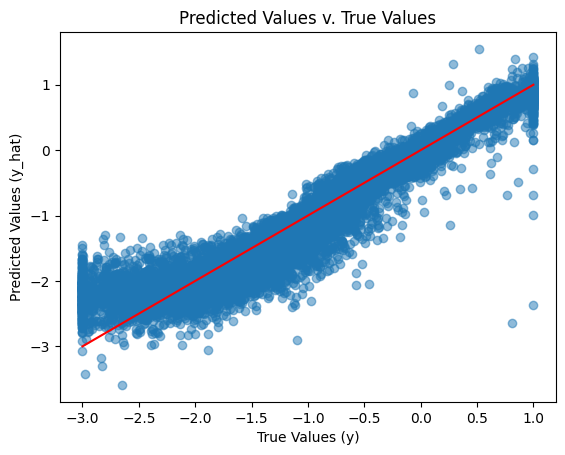

In [5]:
# Plot of y_hat against y, with a one-to-one line overlayed
# plot y_hat against y 
plt.scatter(y, y_hat, alpha=0.5)  

# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)") 
plt.title('Predicted Values v. True Values')

# one-to-one line overlay 
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  

Text(0.5, 1.0, 'Histogram of the Residuals')

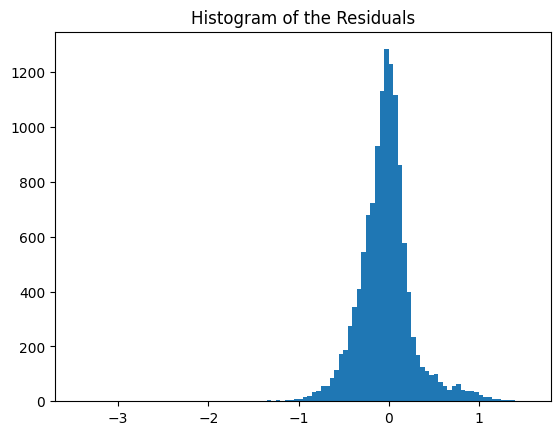

In [13]:
# Plot a histogram of the residuals
residual = y_hat - y  
num_bins = 100 
plt.hist(residual, num_bins) 
plt.title("Histogram of the Residuals")


Text(0.5, 1.0, 'Residuals v. True Values')

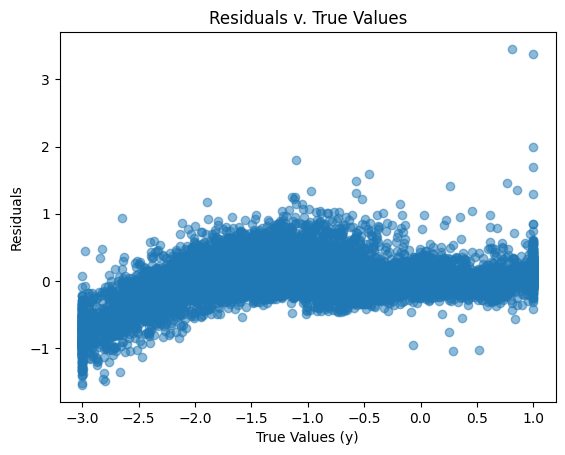

In [7]:
# Plot of the residuals against y 
plt.scatter(y, residual, alpha=0.5) 
# lables 
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title('Residuals v. True Values')

## Heat Maps 

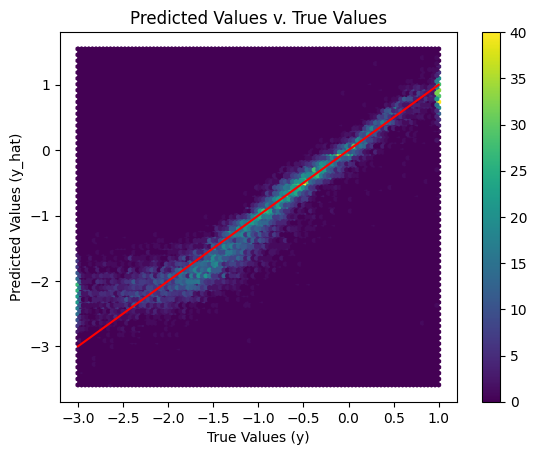

In [12]:
# Heat map of y_hat against y  

# create the heatmap of y_hat against y  
plt.hexbin(y, y_hat, cmap = 'viridis')    
# set the size of the graph 
plt.axis('auto') 
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)") 
plt.title('Predicted Values v. True Values')  
# one-to-one line overlay 
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  
plt.colorbar() 

In [ ]:
# Heat map of residuals (y = y_hat + residual)   
plt.imshow(residual, cmap='viridis', interpolation= 'nearest')    
# set the size of the graph 
plt.axis('auto') 
# lables
#plt.xlabel('True Values')
#plt.ylabel('Predicted Values')
plt.title('Heat Map of the Residuals') 
plt.colorbar() 

Text(0.5, 1.0, 'Residuals v. True Values')

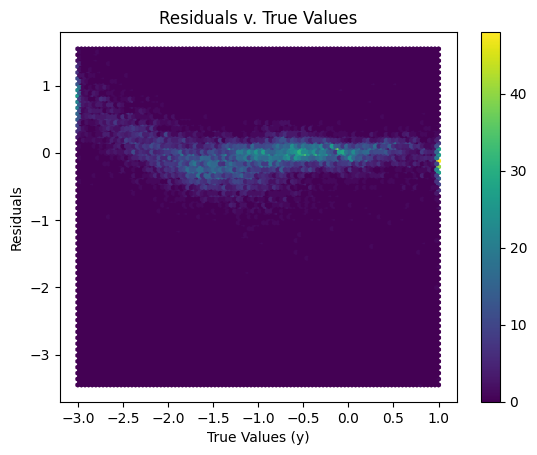

In [18]:
# Heat map of the residuals against y  

# create the heatmap of residuals against y  
plt.hexbin(y, residual, cmap='viridis')    
plt.colorbar() 
# set the size of the graph 
plt.axis('auto') 
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title('Residuals v. True Values')